<a href="https://colab.research.google.com/github/gabelstapler6/QuickDrawClassification/blob/main/challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning challenge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Objective
The objective of this challenge is to develop a deep learning based classification method to classify images from [Google Quickdraw](https://quickdraw.withgoogle.com/data).


## Data 
Among all the available images, you will work on a dataset composed of 5 balanced classes, with 15000 training examples and 5000 test examples: baskets, eyes, glasses, rabbits and hands. The archive *Data_train_test.zip* contains the set of images, as well as two CSV files, giving the lists of images used for the training/test step. 

## Methodology
You can use any algorithm that seems relevant to you (MLP, CNN, LSTM, transfer Learning,...), or even create your own neural network ! Find a relevant methodology, evaluate several architectures (use of dropout, batch Normalisation, use of pretrained netorks with fine tuning... ), objective functions, optimizers.... Take a look at the influence of the parameters (learning rate, batch size, ...). Be imaginative !!


## Evaluation
You have to write a final report in a **jupyter notebook**. The code will be done in Python, the comments in Markdown. 
In this report, you will detail all the steps that led you to the final results, the code you produce, all the experiments you made (different architectures, different parameters, the way you measure the performance of your method,...) with **relevant** comments.

In order not to train all your models by myself, please save your **final** model using the [`save_weights`](https://keras.io/api/models/model_saving_apis/) method. For example:

`model = tf.keras.Sequential([tf.keras.layers.Dense(5, input_shape=(3,)),tf.keras.layers.Softmax()])`

`model.compile(...)`

`model.fit(...)`

`model.save_weights('mymodel.h5')`

Please provide the `.h5` file as well as the full jupyter notebook.



I have a validation set to validate your trained network. I will run your model on this dataset to measure the classification accuracy. 

To give the final mark, the following criteria will be used:
- I will rank you w.r.t. to the accuracy on the validation set. The ranking will provide a part (8/20) of the note (8 points for the best accuracy down to 2 points for the worst)
- The report will provide the remaining 12 points. I will assess the experiments you have made, the final model itself, the comments and the conclusions you have drawn, the results you  have obtained

The report, as well as the `.h5`file, are due **July 5th 2021** on the GRISP  platform.

## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import os.path
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns

from random import randrange

!pip install -q -U keras-tuner

import keras_tuner as kt

     |████████████████████████████████| 102kB 6.9MB/s 


## Parameters


In [ ]:
# Use the correct directory
data_dir = "/content/drive/MyDrive/DeepLearning/Challenge/Data_train_test/"
model_dir = "/content/drive/MyDrive/DeepLearning/Challenge/Models/"

classes = ["basket","eye","binoculars","rabbit","hand"]
num_classes = 5

image_width = 28
image_height = 28
image_channels = 3

batch_size = 40

## Retrieve the dataset(s)
- We need to retrieve the data specified in the two .csv files
- One data set for training and the other for testing

### Evaluating the approach for retrieving the datasets

The images need to be loaded from the Google Drive into the memory so that they can be processed by the neural net. There are some different approaches to do that.

#### First approach: "Flow from dataframe"

Pros:
- Easy to implement and understand
- Good for large datasets due to the loading of data into the RAM only when needed (e.g. when fitting the dataset)
- Creation of the generator objects is fast

Cons:
- Fitting needs very much time because the data needs to be read from the Google drive for each batch

##### Example code:

In [ ]:
if 0:
  datagen = ImageDataGenerator(rescale=1./255.)

  train_df = pd.read_csv(data_dir + 'train.csv')

  train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = data_dir + "images/",
    x_col = "relative_path",
    y_col = "class_label",
    batch_size = batch_size,
    seed = 42,
    shuffle = True,
    class_mode = "raw",
    target_size = (image_height, image_width)
  )

This approach was the first to be used to retrieve the dataset. It was a failure due to the extreme fitting duration. The evaluation of the model was not possible because the colab session timed out before even reaching  completion of the first epoch. A bug resulted the fitting to freeze at the last batch of the epoch. The bug was fixed when setting the "steps_per_epoch" and "validation_steps" parameters of the fit function manualy. 

#### Second approach: "Numpy array"

Pros:
- Fitting the model is very fast because the dataset is already in the RAM
- Saving the numpy array to a file is possible and very fast
- Loading the numpy array from a file is extremely fast compared to loading the images from the Google drive

Cons:
- Reading the dataset at the first run takes very long (~6h)

In the following the second approach is used due to the convenience of saving the dataset in a "ready to use" format to the disk and the possibility to load it. The first time retrieving the data needed to be withstanded but then the dataset could be used nearly instantly to fit and develop the model.

---

### Define some convenience functions

The images can be loaded from disk using the "relative_path" column of the .csv files and put into a numpy array (e.g. x_train.shape: (75000, 28, 28, 3)). The corresponding labels where retrieved using the "class_label" column. The keras function "load_img" returns a PIL image which is "automatically" converted into a numpy array when putting it into one.


In [ ]:
def preprocess_data(dataframe):
  dataframe_size = len(dataframe.relative_path)
  x = np.empty((dataframe_size, image_height, image_width, image_channels))
  y = np.empty(dataframe_size)
  print("Start loading images...")
  for i in range(0, dataframe_size):
    img = tf.keras.preprocessing.image.load_img(data_dir + "images/" + dataframe.relative_path[i], target_size=(image_height, image_width))
    x[i] = img
    y[i] = dataframe.class_label[i]
    if (i+1) % 100 == 0:
      print("Loaded " + str(i+1) + "/" + str(dataframe_size))
  # normalize the pixel values
  x = x / 255.0
  return x, y

The "retrieve_data" function is used for managing the saving and loading of the dataset to the disk as well as calling the "preprocess_data" function to load the images from the Google drive.

In [ ]:
def retrieve_data(dataframe, save_path_x, save_path_y):
  if os.path.isfile(save_path_x) & os.path.isfile(save_path_y):
    print("Found save files:\n" + save_path_x + "\n" + save_path_y)
    x = np.load(save_path_x)
    y = np.load(save_path_y)
    return x, y
  else:
    x, y = preprocess_data(dataframe)
    np.save(save_path_x, x)
    np.save(save_path_y, y)
    return x, y

### Loading the datasets into the memory

In [ ]:
train_df = pd.read_csv(data_dir + 'train.csv')

print("Retrieve train data:")
x_train, y_train = retrieve_data(train_df, data_dir + "npy/x_train.npy", data_dir + "npy/y_train.npy")

Retrieve train data:
Found save files:
/content/drive/MyDrive/DeepLearning/Challenge/Data_train_test/npy/x_train.npy
/content/drive/MyDrive/DeepLearning/Challenge/Data_train_test/npy/y_train.npy


In [ ]:
test_df = pd.read_csv(data_dir + 'test.csv')

print("Retrieve test data:")
x_test, y_test = retrieve_data(test_df, data_dir + "npy/x_test.npy", data_dir + "npy/y_test.npy")

Retrieve test data:
Found save files:
/content/drive/MyDrive/DeepLearning/Challenge/Data_train_test/npy/x_test.npy
/content/drive/MyDrive/DeepLearning/Challenge/Data_train_test/npy/y_test.npy


### Visualize the data


- Plot some random images and their corresponding label from the training set to confirm the data

In [ ]:
def visualize_data(x_data, y_data):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    rand = randrange(len(x_data))
    img = x_data[rand]
    plt.imshow(img)
    label = int(y_data[rand])
    plt.title(classes[label])
    plt.axis("off")

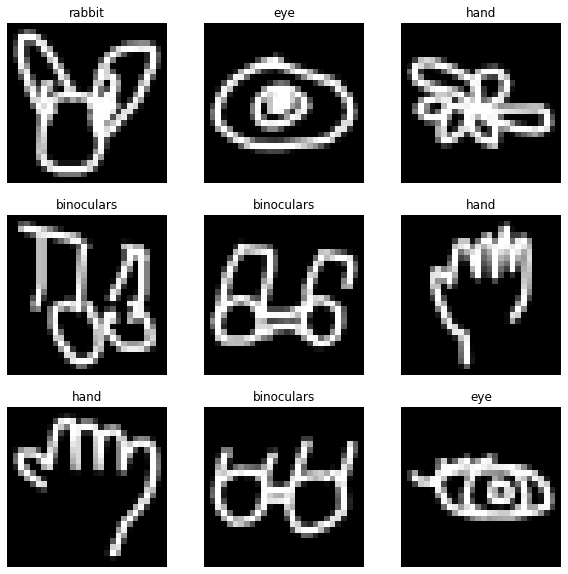

In [ ]:
visualize_data(x_train, y_train)

## Creating the classification model

In [ ]:
def create_mlp_model(name):
  model = keras.Sequential(name=name)
  model.add(keras.layers.Flatten(input_shape=(image_height, image_width, image_channels)))
  model.add(keras.layers.Dense(units=128, activation="tanh"))
  model.add(keras.layers.Dense(units=64, activation="tanh"))
  model.add(keras.layers.Dense(units=64, activation="tanh"))
  model.add(keras.layers.Dense(units=5, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
mlp_model = create_mlp_model("mlp_model")
mlp_model.summary()

Model: "mlp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               301184    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 325       
Total params: 313,925
Trainable params: 313,925
Non-trainable params: 0
_________________________________________________________________


#### Compile and fit the model


Specifying some callback functions to be called during the fitting process
- EarlyStopping
  - Stop the fitting if the monitor value gets worse after the number of epochs specified in patience
- CSVLogger
  - Save the training history into a .csv file after each epoch

In [ ]:
def get_callbacks(name):
  callbacks = [
               tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4),
               keras.callbacks.CSVLogger(model_dir + name + ".history")
               ]
  return callbacks

This function is responsible for fitting the model as well as saving the trained weights to the Drive. If weights are already saved this function retrieves the weights and loads them into the model.

In [ ]:
def fit_model(model, epochs, force_fit=False, verbose=1):

  weights_path = model_dir + model.name + ".h5"
  history_path = model_dir + model.name + ".history"
  
  if not force_fit:
    if os.path.isfile(weights_path) & os.path.isfile(history_path):
      print("Found weights and training history for " + model.name + " at:\n" + weights_path + "\n" + history_path)
      model.load_weights(weights_path)
      return pd.read_csv(history_path)

  print("Fitting " + model.name + " ...\n")
  steps_per_epoch = len(x_train) // batch_size
  validation_steps = len(x_test) // batch_size

  history = model.fit(
      x = x_train,
      y = y_train,  
      steps_per_epoch = steps_per_epoch,
      validation_data = (x_test, y_test),
      validation_steps = validation_steps,
      epochs = epochs,
      batch_size = batch_size,
      shuffle = True,
      verbose = verbose,
      callbacks = get_callbacks(model.name)
  )

  model.save_weights(weights_path)

  print("Finished fitting!")
  return pd.DataFrame(history.history)

Calling the above defined function for fitting.

In [ ]:
mlp_model_history = fit_model(mlp_model, epochs=20)

Fitting mlp_model ...

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5496 - accuracy: 0.8171 - val_loss: 0.4356 - val_accuracy: 0.8601
Epoch 2/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4007 - accuracy: 0.8691 - val_loss: 0.4249 - val_accuracy: 0.8621
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3552 - accuracy: 0.8834 - val_loss: 0.3949 - val_accuracy: 0.8724
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3265 - accuracy: 0.8916 - val_loss: 0.3856 - val_accuracy: 0.8743
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3011 - accuracy: 0.9009 - val_loss: 0.3870 - val_accuracy: 0.8722
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2821 - accuracy: 0.9053 - val_loss: 0.3869 - val_accuracy: 0.8745
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2642 - accuracy: 0.9120 - val_loss:

#### Evaluate the model

Reusable function for plotting the accuracy of the training and the validation set, as well as the losses.

In [ ]:
def visualize_accuracy_and_loss(history, name=""):
  acc = history.accuracy
  val_acc = history.val_accuracy

  loss = history.loss
  val_loss = history.val_loss

  epochs_range = range(len(history.accuracy))

  plt.figure(figsize=(7, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label="Training Accuracy")
  plt.plot(epochs_range, val_acc, label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.title("Accuracy " + name)

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label="Training Loss")
  plt.plot(epochs_range, val_loss, label="Validation Loss")
  plt.legend(loc="upper right")
  plt.title("Loss " + name)
  plt.show()

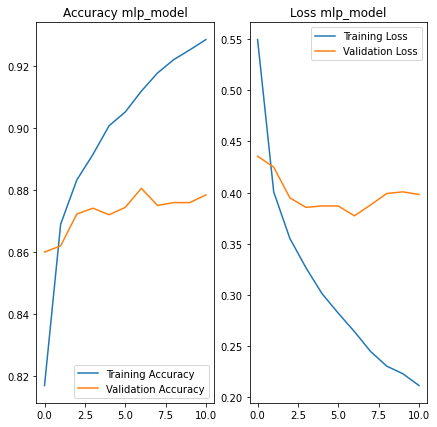

In [ ]:
visualize_accuracy_and_loss(mlp_model_history, mlp_model.name)

the shape of the curves tells us that the model quickly starts to overfit on the training set.

Confusion Matrix

The confusion matrix shows the predicted and true labels for all classes in the test dataset.

In [ ]:
def plot_confusion_matrix(model):
  y_true, y_pred = y_test, np.argmax(model.predict(x_test), axis=-1)
  cm = confusion_matrix(y_true, y_pred)

  fig, ax = plt.subplots(figsize=(7, 7))     
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, cmap="Greens", fmt="g")
  ax.set_xlabel("\nPredicted labels", fontsize=14)
  ax.set_ylabel("\nTrue labels", fontsize=14)
  ax.set_title("Confusion Matrix " + model.name)
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.show()

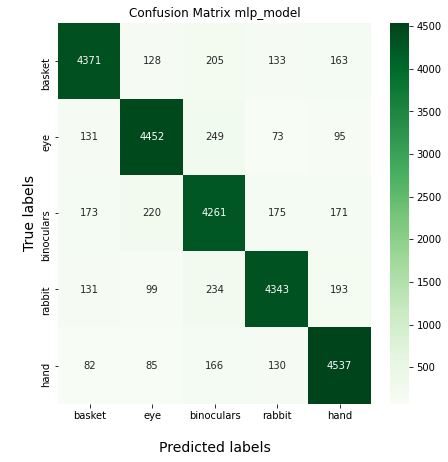

In [ ]:
plot_confusion_matrix(mlp_model)

In [ ]:
def get_final_accuracy(model, x, y):
  scores = model.evaluate(x=x, y=y, verbose=0)
  scores = round(scores[1]*100, 2)
  print("Final accuracy for " + model.name + ": " + str(scores) +  "%")

In [ ]:
get_final_accuracy(mlp_model, x_test, y_test)

Final accuracy for mlp_model: 87.86%


The final accuracy on the test dataset is pretty good using the MLP model. To prevent overfitting Dropout layers can be added.

In [ ]:
def create_mlp_dropout_model(name):
  model = keras.Sequential(name=name)
  model.add(keras.layers.Flatten(input_shape=(image_height, image_width, image_channels)))
  model.add(keras.layers.Dense(units=128, activation="tanh"))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(units=64, activation="tanh"))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(units=64, activation="tanh"))
  model.add(keras.layers.Dense(units=5, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

The process_model function bundles all above functions into one call for convenience.

In [ ]:
def process_model(model, print_summary=True, epochs=10, force_fit=False, fitting_verbose=0):
  if print_summary:
    model.summary()
    print("\n")
  history = fit_model(model, epochs=epochs, force_fit=force_fit, verbose=fitting_verbose)
  print("\n")
  visualize_accuracy_and_loss(history, model.name)
  print("\n")
  plot_confusion_matrix(model)
  print("\n")
  get_final_accuracy(model, x_test, y_test)

Model: "mlp_dropout_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               301184    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 5)           

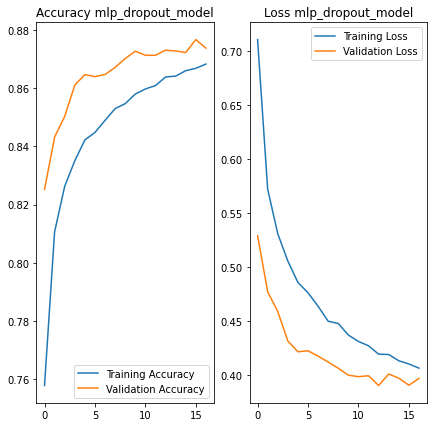

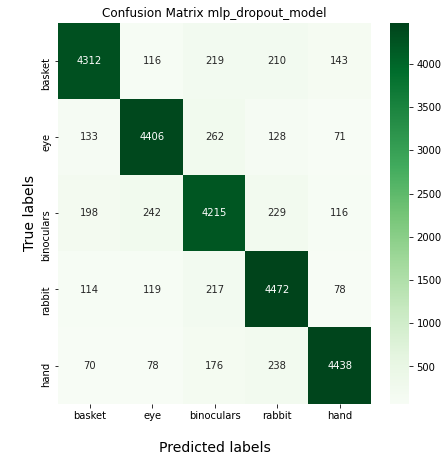



Final accuracy for mlp_dropout_model: 87.37%


In [ ]:
mlp_dropout_model = create_mlp_dropout_model("mlp_dropout_model")
process_model(mlp_dropout_model, epochs=20)

You can see that the shapes of the curves have changed drastically. The validation accuracy is now higher than the training accuracy, but the final accuracy is even worse than before. It can be concluded that using a MLP for classifying the QuickDraw dataset is not a good choice. The next best option is a CNN. The CNN can probably identify more patterns and generalize them better, because of the convolution layers.

### TensorFlow [Image classification example](https://www.tensorflow.org/tutorials/images/classification) architecture

The example model is used as a starting point and to test the dataset.


In [ ]:
def create_example_cnn_model(name):
  model = keras.Sequential(name=name)
  model.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape=(image_height, image_width, image_channels)))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Dropout(rate=0.3))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=128, activation="relu"))
  model.add(keras.layers.Dropout(rate=0.3))
  model.add(keras.layers.Dense(units=num_classes, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
example_cnn_model = create_example_cnn_model("example_cnn_model")
process_model(example_cnn_model, epochs=20)

#### Beat the example model in the performance

The example cnn already classifies pretty good. By adding a second Fully connected layer the validation accuracy increases by <1% 

In [ ]:
def create_cnn_model(name):
  model = keras.Sequential(name=name)

  model.add(keras.layers.Conv2D(filters=16, kernel_size=(5,5), padding="same", activation="relu", input_shape=(image_height, image_width, image_channels)))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D())

  model.add(keras.layers.Dropout(rate=0.3))
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(units=128, activation="relu"))
  model.add(keras.layers.Dropout(rate=0.3))
  model.add(keras.layers.Dense(units=64, activation="relu"))
  model.add(keras.layers.Dropout(rate=0.3))

  model.add(keras.layers.Dense(units=num_classes, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 3, 64)          0 

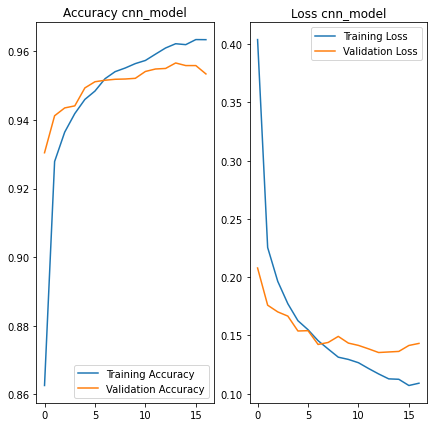

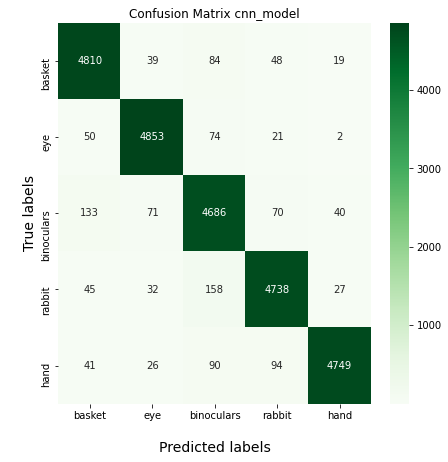



Final accuracy for cnn_model: 95.34%


In [ ]:
cnn_model = create_cnn_model("cnn_model")
process_model(cnn_model, epochs=20, fitting_verbose=1)

#### Tuning the hyperparameters of the cnn

In [ ]:
def create_cnn_hypermodel(hp):
  model = keras.Sequential()

  hp_filters = hp.Int("conv1_filters", min_value=16, max_value=256, step=16)
  model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=(5,5), padding="same", activation="relu", input_shape=(image_height, image_width, image_channels)))
  model.add(keras.layers.MaxPooling2D())

  hp_filters = hp.Int("conv2_filters", min_value=16, max_value=256, step=16)
  model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D())

  hp_filters = hp.Int("conv3_filters", min_value=16, max_value=256, step=16)
  model.add(keras.layers.Conv2D(filters=hp_filters, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D())

  model.add(keras.layers.Dropout(rate=0.3))
  model.add(keras.layers.Flatten())

  hp_units = hp.Int("fc1_units", min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation="relu"))
  model.add(keras.layers.Dropout(rate=0.3))

  hp_units = hp.Int("fc2_units", min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation="relu"))
  model.add(keras.layers.Dropout(rate=0.3))

  model.add(keras.layers.Dense(units=num_classes, activation="softmax"))

  hp_learning_rate = hp.Choice("learning_rate", values=[0.01, 0.001, 0.0001])
  optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

  loss = keras.losses.SparseCategoricalCrossentropy()

  model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
  return model

In [ ]:
tuner = kt.tuners.Hyperband(create_cnn_hypermodel,
                     objective="val_accuracy",
                     max_epochs=10,
                     factor=3,
                     directory=model_dir,
                     project_name="cnn_hypermodel")

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_hypermodel/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/DeepLearning/Challenge/Models/cnn_hypermodel/tuner0.json


In [ ]:
tuner.search(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=get_callbacks("cnn_hypermodel"))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 7 Complete [00h 01m 22s]
val_accuracy: 0.9498800039291382

Best val_accuracy So Far: 0.9582399725914001
Total elapsed time: 00h 11m 03s

Search: Running Trial #8

Hyperparameter    |Value             |Best Value So Far 
conv1_filters     |240               |256               
conv2_filters     |192               |80                
conv3_filters     |192               |240               
fc1_units         |256               |384               
fc2_units         |448               |192               
learning_rate     |0.0001            |0.001             
tuner/epochs      |4                 |10                
tuner/initial_e...|0                 |4                 
tuner/bracket     |1                 |2                 
tuner/round       |0                 |2                 

Epoch 1/4
2344/2344 [==============================] - 24s 10ms/step - loss: 0.4415 - accuracy: 0.8497 - val_loss: 0.2264 - val_accuracy: 0.9264
Epoch 2/4
1635/2344 [===================>..........] - ETA

In [ ]:
print("Best value for conv1_filters: " + str(best_hps.get("conv1_filters")))
print("Best value for conv2_filters: " + str(best_hps.get("conv2_filters")))
print("Best value for conv3_filters: " + str(best_hps.get("conv3_filters")))
print("Best value for fc1_units: " + str(best_hps.get("fc1_units")))
print("Best value for fc2_units: " + str(best_hps.get("fc2_units")))
print("Best value for learning_rate: " + str(best_hps.get("learning_rate")))

## Test setup

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
x_test_shuffled, y_test_shuffled = unison_shuffled_copies(x_test, y_test)

In [ ]:
get_final_accuracy(cnn_rnn_model, x_test_shuffled, y_test_shuffled)

Final accuracy for cnn_rnn_model: 95.66%


In [ ]:
def plot_prediction(predictions_array, true_label, img):
  plt.figure(figsize=(10,3))
  plt.subplot(1,2,1)

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                100*np.max(predictions_array),
                                classes[true_label]),
                                color=color)
  ax = plt.subplot(1,2,2)

  plt.grid(False)
  plt.xticks(range(5))
  ax.xaxis.set_ticklabels(classes)
  plt.yticks([])
  thisplot = plt.bar(range(5), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

  plt.show()


In [ ]:
def test_model_with_one_img(path_to_image, true_label, model):
  img = tf.keras.preprocessing.image.load_img(
    path_to_image,
    target_size=(image_height, image_width)
  )

  img_array = np.empty((1, image_height, image_width, image_channels))
  img_array[0] = img

  img_array = img_array / 255.0

  predictions = model.predict(img_array)

  plot_prediction(predictions[0], true_label, img_array)

In [ ]:
def test_model_with_my_drawings(model):
  # index in array represents the corresponding class label (y)
  my_drawings_paths = [
                      data_dir + "my_basket.png",
                      data_dir + "my_eye.png",
                      data_dir + "my_binoculars.png",
                      data_dir + "my_rabbit.png",
                      data_dir + "my_hand.png"
  ]

  for i in range(len(my_drawings_paths)):
    test_model_with_one_img(my_drawings_paths[i], i, model)


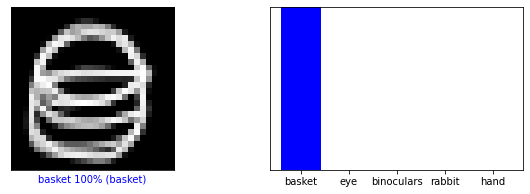

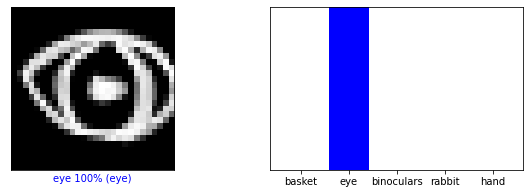

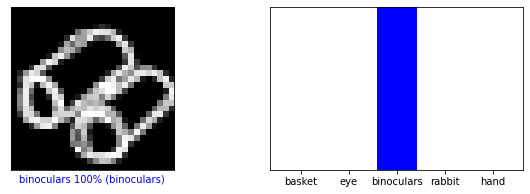

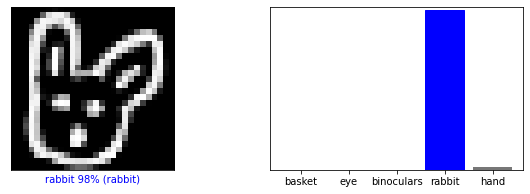

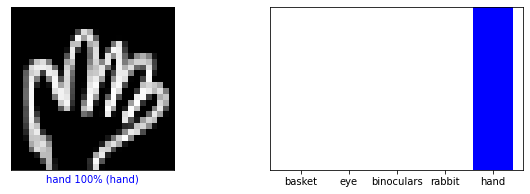

In [ ]:
test_model_with_my_drawings(cnn_rnn_model)

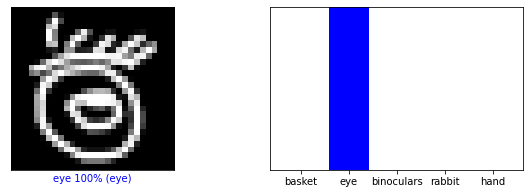

In [ ]:
test_img = np.empty((1, image_height, image_width, image_channels))
num = randrange(len(x_test))
test_img[0] = x_test[num]

predictions = cnn_rnn_model.predict(test_img)
plot_prediction(predictions[0], int(y_test[num]), test_img)

##Test with unknown data

In [ ]:
if 0:
  %load_ext tensorboard
  %tensorboard --logdir logs